In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Load your dataset
df = pd.read_csv("../data/OZ_GLCM_Fullprint_ROI.csv")
print(df.columns)

Index(['number', 'Filename', 'category', 'class', 'duration',
       'Dissimilarity 0', 'Dissimilarity 45', 'Dissimilarity 90',
       'Dissimilarity 135', 'Energy 0', 'Energy 45', 'Energy 90', 'Energy 135',
       'Homogeneity 0', 'Homogeneity 45', 'Homogeneity 90', 'Homogeneity 135',
       'Contrast 0', 'Contrast 45', 'Contrast 90', 'Contrast 135',
       'Correlation 0', 'Correlation 45', 'Correlation 90', 'Correlation 135'],
      dtype='object')


In [3]:
# Define GLCM features and label
glcm_features = [
    'Dissimilarity 0', 'Dissimilarity 45', 'Dissimilarity 90', 'Dissimilarity 135',
    'Energy 0', 'Energy 45', 'Energy 90', 'Energy 135',
    'Homogeneity 0', 'Homogeneity 45', 'Homogeneity 90', 'Homogeneity 135'
]

X = df[glcm_features]
y = df['class']  # Ensure 'label' column is present

In [4]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

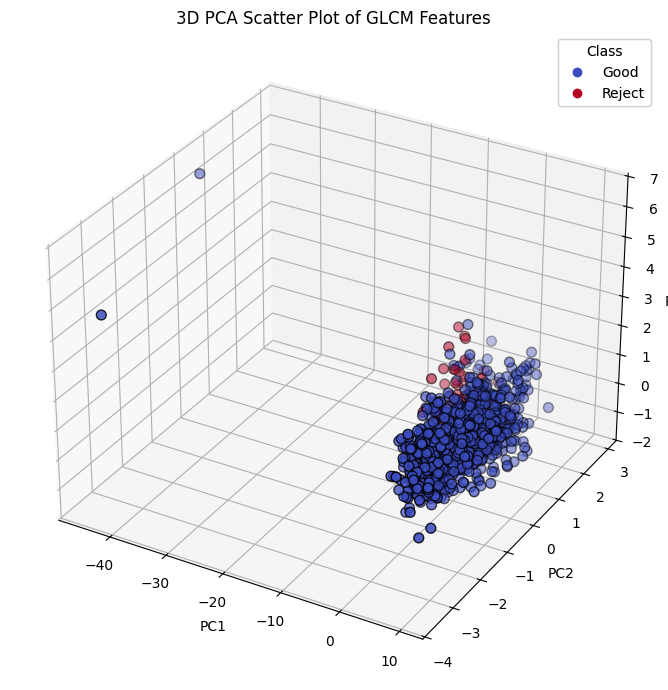

In [15]:
# 🌐 3D PCA Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=y, cmap='coolwarm', edgecolor='k', s=50)
ax.set_title("3D PCA Scatter Plot of GLCM Features")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Update legend labels
legend_labels = {0: 'Good', 1: 'Reject'}
handles, labels = scatter.legend_elements()
# mapped_labels = [legend_labels[int(label[1:-1])] for label in labels]
# Clean labels to extract numeric values
cleaned_labels = [int(label.replace('$\\mathdefault{', '').replace('}$', '')) for label in labels]
mapped_labels = [legend_labels[label] for label in cleaned_labels]

legend = ax.legend(handles, mapped_labels, title="Class")
ax.add_artist(legend)

plt.tight_layout()
plt.show()

In [9]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.3, random_state=42)

In [10]:
# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

d:\projects\BDD\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [11]:
# Define classifiers
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        use_label_encoder=False,
        eval_metric='logloss'
    )
}


=== Random Forest ===
              precision    recall  f1-score   support

        Good       1.00      0.98      0.99       414
      Reject       0.60      0.86      0.71        14

    accuracy                           0.98       428
   macro avg       0.80      0.92      0.85       428
weighted avg       0.98      0.98      0.98       428



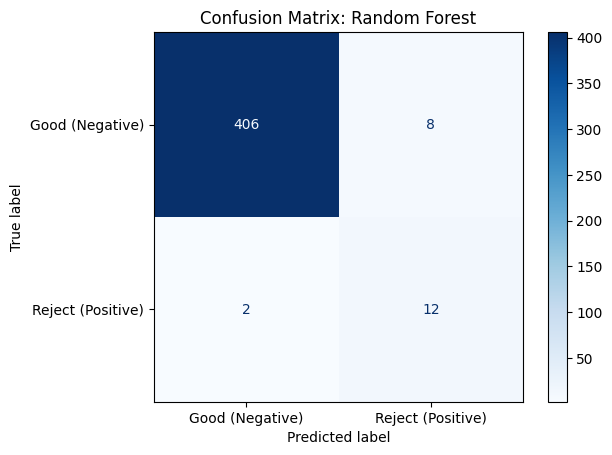


=== XGBoost ===
              precision    recall  f1-score   support

        Good       1.00      0.98      0.99       414
      Reject       0.55      0.86      0.67        14

    accuracy                           0.97       428
   macro avg       0.77      0.92      0.83       428
weighted avg       0.98      0.97      0.97       428



d:\projects\BDD\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


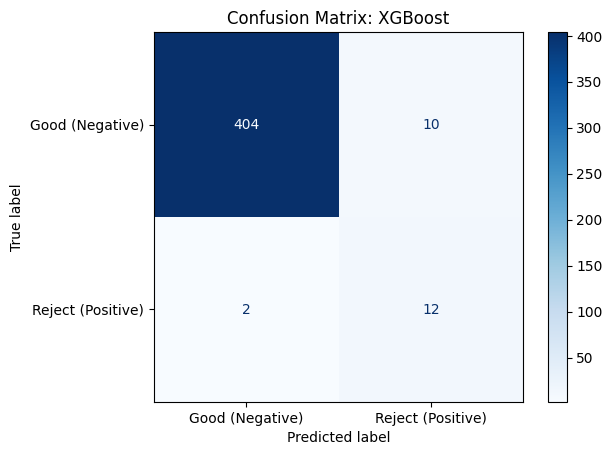

In [ ]:
# Train, evaluate, and show confusion matrix for each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    # Classification Report
    print(classification_report(y_test, y_pred, target_names=["Good", "Reject"]))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good", "Reject"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.grid(False)
    plt.show()